# 1st Model: Original Model Taken from Kaggle Notebook

https://www.kaggle.com/code/jonathanoheix/face-expression-recognition-with-deep-learning

In [2]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
! pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/2d/30/3afb8bcb785653254eb646ff2680ec4d637b40b06f4b046aca17b5e086b0/scikit_learn-1.3.0-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/96/9b/10048be0c335327077af430c5a6637c0b9e7fe9121a8048836f1bb022a81/scipy-1.11.1-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.1 kB ? eta -:--:--
     -------------------- ------------------- 30.7/59.1 kB 1.4 MB/s eta 0:00:01
     ---------------------------------------- 59.1/59.1 kB 1.6 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 k

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from tensorflow.keras.models import Sequential


In [3]:
! pip install seaborn

In [4]:
! pip install matplotlib

In [5]:
! pip install scikit-learn

In [27]:
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

In [28]:
data_folder = pathlib.Path('../../facial_expression_recognition/images')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(48, 48),
    label_mode='categorical',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(48, 48),
    label_mode='categorical',
    batch_size=32)

Found 28821 files belonging to 7 classes.
Found 7066 files belonging to 7 classes.


In [17]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

tf.Tensor(
[[[[  9.   9.   9.]
   [  7.   7.   7.]
   [  6.   6.   6.]
   ...
   [ 28.  28.  28.]
   [ 17.  17.  17.]
   [ 69.  69.  69.]]

  [[  2.   2.   2.]
   [  9.   9.   9.]
   [  8.   8.   8.]
   ...
   [ 23.  23.  23.]
   [ 29.  29.  29.]
   [ 70.  70.  70.]]

  [[  4.   4.   4.]
   [  3.   3.   3.]
   [  8.   8.   8.]
   ...
   [  0.   0.   0.]
   [ 14.  14.  14.]
   [ 57.  57.  57.]]

  ...

  [[  5.   5.   5.]
   [  5.   5.   5.]
   [  1.   1.   1.]
   ...
   [162. 162. 162.]
   [161. 161. 161.]
   [155. 155. 155.]]

  [[  1.   1.   1.]
   [  0.   0.   0.]
   [  0.   0.   0.]
   ...
   [159. 159. 159.]
   [159. 159. 159.]
   [154. 154. 154.]]

  [[  0.   0.   0.]
   [  1.   1.   1.]
   [  0.   0.   0.]
   ...
   [153. 153. 153.]
   [156. 156. 156.]
   [153. 153. 153.]]]


 [[[ 50.  50.  50.]
   [ 22.  22.  22.]
   [  9.   9.   9.]
   ...
   [ 86.  86.  86.]
   [ 95.  95.  95.]
   [104. 104. 104.]]

  [[ 44.  44.  44.]
   [ 14.  14.  14.]
   [  8.   8.   8.]
   ...
   [ 94.  

In [9]:
for data_batch, labels_batch in validation_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 48, 48, 3)
labels batch shape: (32, 7)


In [10]:
! pip install pillow

Draw some sample images from the dataset

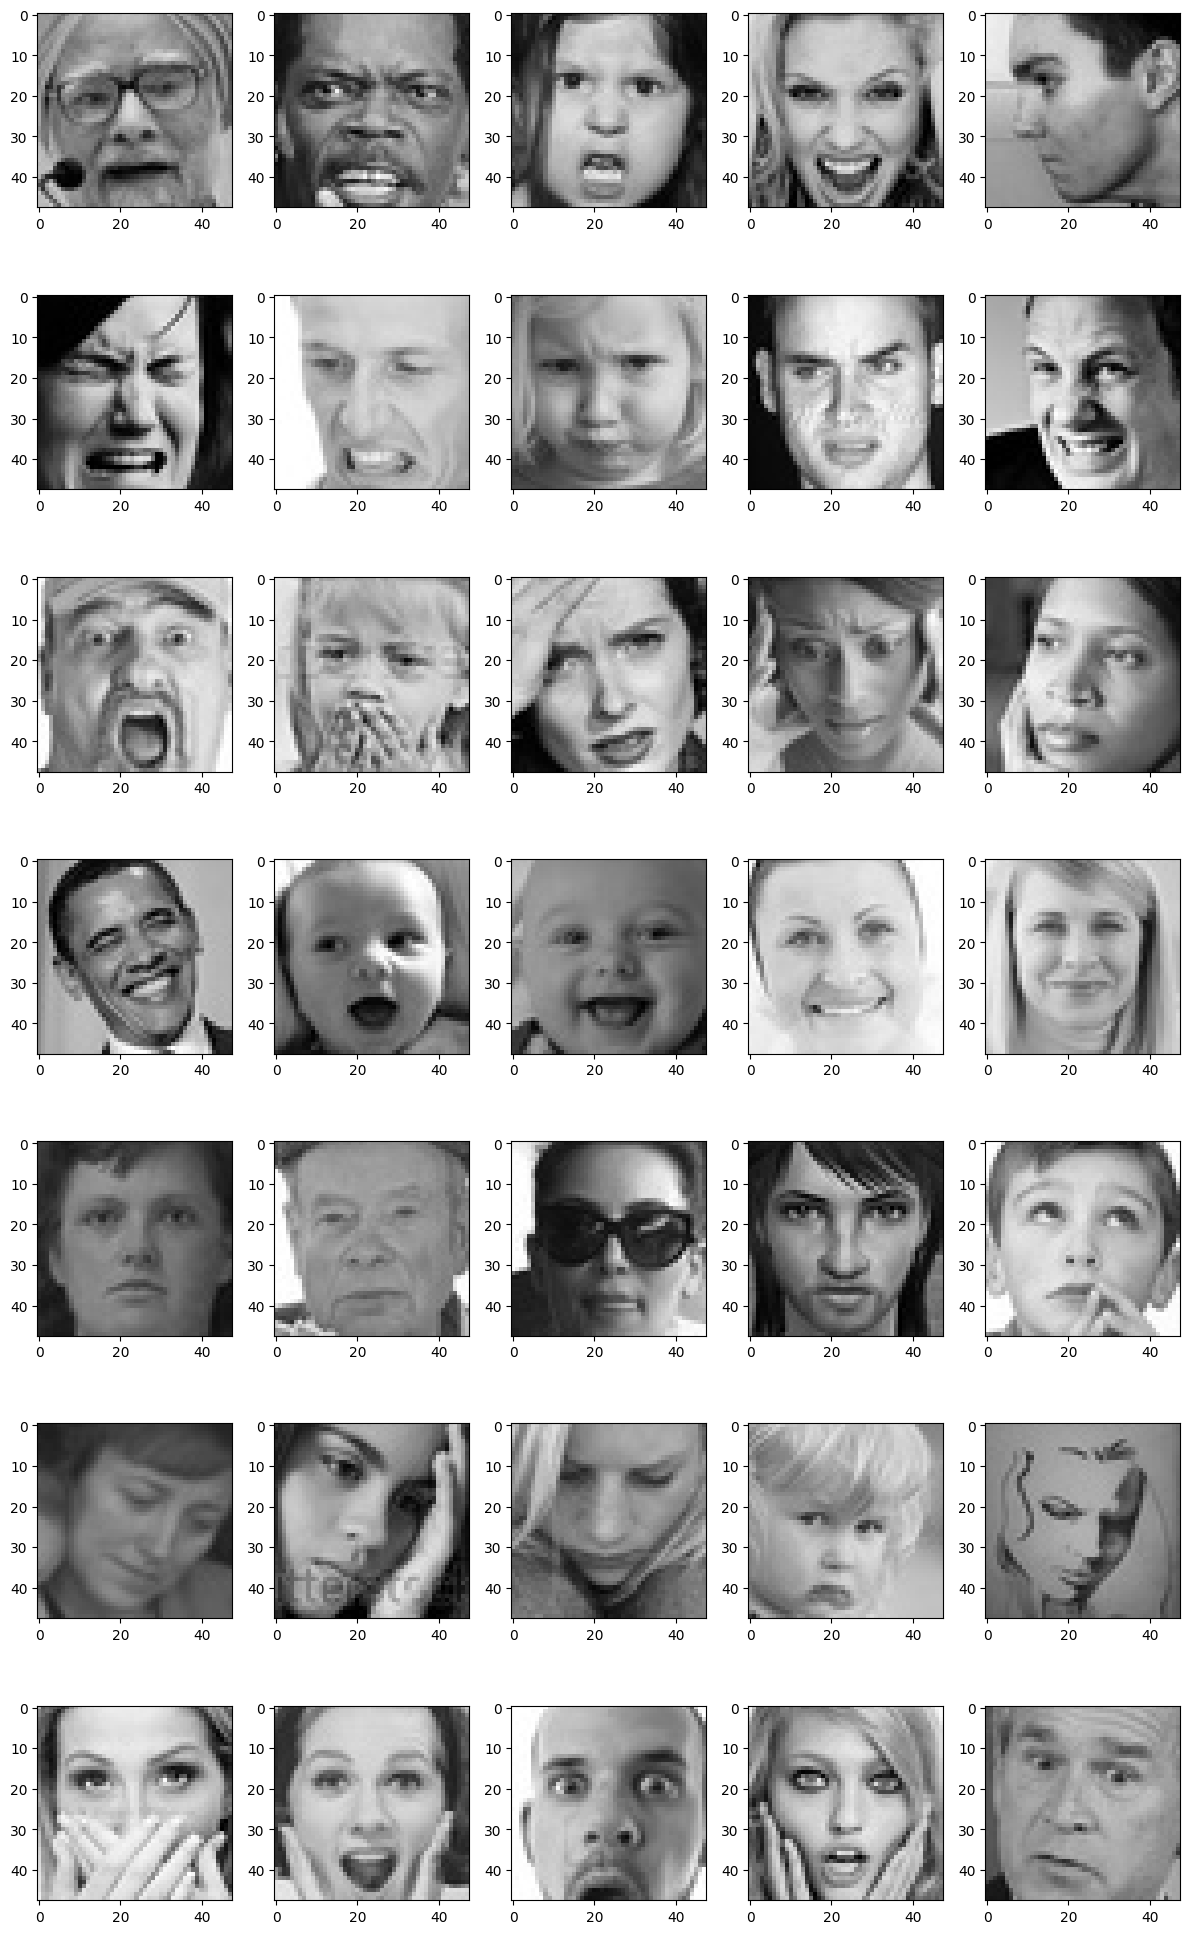

In [4]:
import numpy as np
import seaborn as sns
from tensorflow.keras.utils import load_img
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "../../facial_expression_recognition/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [5]:
# count number of train images for each expression

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


Class distribtuion is imbalanced in terms of Happy and Disgust images. Therefore, use ImageDataGenerator to retrieve images and augment them.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [7]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow import keras


This is the original model taken from Kaggle notebook. We run it in our local computer to see its performance. 

In [14]:

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))


In [15]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50


C:\Users\duygu\AppData\Local\Temp\ipykernel_38632\1791765590.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


225/225 [==============================] - 22s 61ms/step - loss: 2.0525 - accuracy: 0.2266 - val_loss: 1.7183 - val_accuracy: 0.3077
Epoch 2/50
225/225 [==============================] - 13s 59ms/step - loss: 1.8140 - accuracy: 0.3042 - val_loss: 1.6551 - val_accuracy: 0.3537
Epoch 3/50
225/225 [==============================] - 13s 59ms/step - loss: 1.7217 - accuracy: 0.3428 - val_loss: 1.6348 - val_accuracy: 0.3683
Epoch 4/50
225/225 [==============================] - 13s 57ms/step - loss: 1.6424 - accuracy: 0.3708 - val_loss: 1.6085 - val_accuracy: 0.3929
Epoch 5/50
225/225 [==============================] - 13s 58ms/step - loss: 1.5922 - accuracy: 0.3871 - val_loss: 1.5122 - val_accuracy: 0.4203
Epoch 6/50
225/225 [==============================] - 14s 60ms/step - loss: 1.5361 - accuracy: 0.4086 - val_loss: 1.5439 - val_accuracy: 0.4261
Epoch 7/50
225/225 [==============================] - 14s 60ms/step - loss: 1.4899 - accuracy: 0.4270 - val_loss: 1.5097 - val_accuracy: 0.4372
Epo

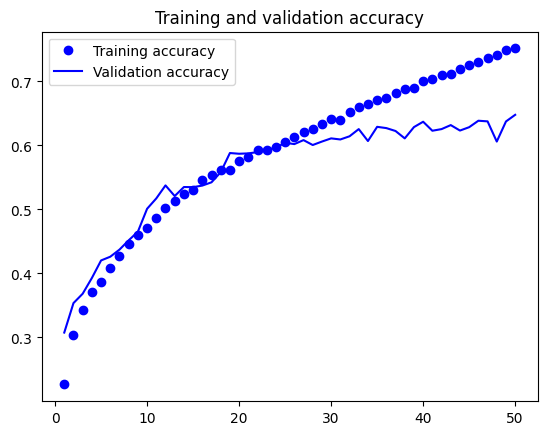

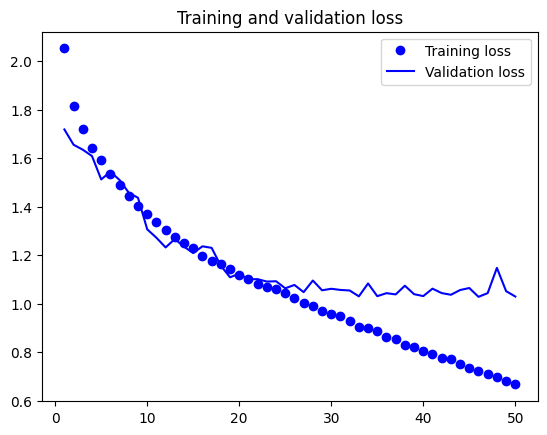

In [17]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Validation accuracy is not increasing more than 0.64. Here, our primary aim will be improving validation accuracy and prevent train data from overfitting. Because we don't have test data.

# 2nd model: Replacing Max Pooling with global average pooling

- The aim of the GlobalAveragePooling2D layer in a neural network is to reduce the spatial dimensions of a 2D feature map while preserving important information. It is often used as a downsampling operation before the final classification layer in convolutional neural networks (CNNs) for tasks like image classification.

- In a CNN, the earlier layers typically learn local features, like edges, textures, and simple shapes. As you move deeper into the network, the learned features become more complex and high-level. The final step in a CNN is often a classification layer that takes these high-level features and makes predictions about the input image's class.


In [20]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48, 48, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D(keepdims=True))   # Here put GlobalAveragePooling2D layer to reduce spatial dimensions
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Dense(nb_classes, activation='softmax'))

In [24]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/average_pooling.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
901/901 [==============================] - 11s 11ms/step - loss: 2.0687 - accuracy: 0.1972 - val_loss: 1.7989 - val_accuracy: 0.2427
Epoch 2/50
901/901 [==============================] - 9s 10ms/step - loss: 1.9452 - accuracy: 0.2059 - val_loss: 1.7879 - val_accuracy: 0.2617
Epoch 3/50
901/901 [==============================] - 10s 11ms/step - loss: 1.9051 - accuracy: 0.2162 - val_loss: 1.7860 - val_accuracy: 0.2622
Epoch 4/50
901/901 [==============================] - 12s 13ms/step - loss: 1.8811 - accuracy: 0.2207 - val_loss: 1.7789 - val_accuracy: 0.2620
Epoch 5/50
901/901 [==============================] - 12s 13ms/step - loss: 1.8604 - accuracy: 0.2195 - val_loss: 1.7799 - val_accuracy: 0.2631
Epoch 6/50
901/901 [==============================] - 10s 11ms/step - loss: 1.8491 - accuracy: 0.2271 - val_loss: 1.7790 - val_accuracy: 0.2560
Epoch 7/50
901/901 [==============================] - 11s 12ms/step - loss: 1.8418 - accuracy: 0.2263 - val_loss: 1.7771 - val_accuracy: 

Train and validation accuracy have dropped considerably. In our opinion, by applying global average pooling , we lost some learned features.

# 3rd model: data augmentation

tensorflow 2.10 data augmentation slows down __[https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting]__ Because of this bug, we couldn't integrate data augmentation step. In order to work with higher versions of tensorflow in Windows, we had to install WSL2, but because of the limited time, so we didn't try it.